In [ ]:

import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from google.colab import files
import pandas as pd

In [ ]:
# Step 1: Load and preprocess images
def load_images(data_path, img_size=(64, 64)):
    data = []
    labels = []
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path):
            class_label = folder
            class_images = os.listdir(folder_path)[:1500]  # Select the first 1500 images
            for img_name in class_images:
                img_path = os.path.join(folder_path, img_name)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                data.append(img_array)
                labels.append(class_label)
    return np.array(data), labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = '/content/drive/MyDrive/archive.zip'

In [ ]:
import zipfile
extracted_folder_path = '/content/extracted_contents'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [ ]:
data_path = "/content/extracted_contents/asl_alphabet_train/asl_alphabet_train"
print(os.listdir(data_path))

['M', 'H', 'B', 'Y', 'P', 'space', 'G', 'Z', 'L', 'T', 'U', 'A', 'S', 'E', 'V', 'del', 'O', 'R', 'D', 'K', 'C', 'nothing', 'Q', 'X', 'W', 'I', 'N', 'F', 'J']


In [ ]:
CODES = {"nothing": 0}
def make_labels():
    alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for i in range(1, 27):
        CODES[alpha[i - 1]] = i

    CODES["del"] = 27
    CODES["space"] = 28
    return CODES

In [ ]:
def code_conv(label, codes):
    return codes[label]

In [ ]:
def preprocess_labels(labels, codes):
    labels = list(map(lambda x: code_conv(x, codes), labels))
    return to_categorical(labels, num_classes=len(codes))

In [ ]:
def normalize_data(data):
    return data.astype('float32') / 255.0

In [ ]:
data, labels = load_images(data_path)
codes = make_labels()
labels = preprocess_labels(labels, codes)
data = normalize_data(data)
# Dimensions of the data
print("Data shape:", data.shape)

# Dimensions of the labels
print("Labels shape:", len(labels))

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.15, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=42)


Data shape: (43500, 64, 64, 3)
Labels shape: 43500


In [ ]:
# Step 3: Load MobileNet pre-trained model
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Dense
from keras.applications import MobileNet
from keras.optimizers import Adam

model = Sequential()
model.add(MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3)))
model.add(GlobalMaxPooling2D())
model.add(Dense(29, activation='softmax'))




17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Step 4: Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 2, 2, 1024)        3228864   
 onal)                                                           
                                                                 
 global_max_pooling2d (Glob  (None, 1024)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 29)                29725     
                                                                 
Total params: 3258589 (12.43 MB)
Trainable params: 3236701 (12.35 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=500, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
 1/61 [..............................] - ETA: 20:31 - loss: 6.8980 - accuracy: 0.0380

KeyboardInterrupt: 

In [ ]:
from google.colab import files

model.save('mobilenet_model.h5')

# Download the model file
files.download('mobilenet_model.h5')

In [ ]:
  # Evaluate the model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
# Dimensions of the data
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

# Dimensions of the labels
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)
print("Test labels shape:", y_test.shape)


In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy from history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs from 0 to 99
epochs = range(0, 100)  # 0-19 inclusive

# Plot training accuracy as dots and validation accuracy as lines
plt.plot(epochs, training_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, len(training_loss) + 1)

# Plot training loss as dots and validation loss as lines
plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Extract training and validation accuracy and loss from history
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

# Get the number of epochs
num_epochs = len(training_accuracy)

# Print the results in percentage
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {training_accuracy[epoch] * 100:.2f}%")
    print(f"Training Loss: {training_loss[epoch] * 100:.2f}%")
    print(f"Validation Accuracy: {validation_accuracy[epoch] * 100:.2f}%")
    print(f"Validation Loss: {validation_loss[epoch] * 100:.2f}%")
    print()


In [ ]:
# Extract training and validation accuracy from history
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

# Calculate total training accuracy and loss
total_training_accuracy = sum(training_accuracy) / len(training_accuracy)
total_training_loss = sum(training_loss) / len(training_loss)

# Calculate total validation accuracy and loss
total_validation_accuracy = sum(validation_accuracy) / len(validation_accuracy)
total_validation_loss = sum(validation_loss) / len(validation_loss)

print("Total Training Accuracy:", total_training_accuracy*100)
print("Total Training Loss:", total_training_loss*100)
print("Total Validation Accuracy:", total_validation_accuracy*100)
print("Total Validation Loss:", total_validation_loss*100)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate predicted probabilities for the test set
y_score = model.predict(X_test)
num_classes=29
# Compute ROC curve and ROC area for each label
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):  # Assuming num_classes is the number of classes in your problem
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each label
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Predict classes for test set
# y_pred = model.predict_classes(X_test)

# Convert one-hot encoded labels back to original labels
y_true = [np.argmax(label) for label in y_test]

# Generate classification report
report = classification_report(y_true, y_pred)

# Print classification report
print("Classification Report:")
print(report)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
# Convert one-hot encoded labels back to original labels
y_true = [np.argmax(label) for label in y_test]

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
def get_model_size_mb(model):
    total_size_bytes = 0
    for layer in model.layers:
        for weight in layer.weights:
            total_size_bytes += weight.numpy().nbytes
    total_size_mb = total_size_bytes / (1024 * 1024)
    return total_size_mb

# Get the size of the model in megabytes
model_size_mb = get_model_size_mb(model)
print("Model size: {:.2f} MB".format(model_size_mb))


In [ ]:
import os

# Get the path to your .h5 file
model_file_path = 'mobilenet_model.h5'  # Replace 'my_model.h5' with the path to your .h5 file

# Get the size of the .h5 file in bytes
model_file_size_bytes = os.path.getsize(model_file_path)

# Convert the size to megabytes
model_file_size_mb = model_file_size_bytes / (1024 * 1024)

print("Model file size: {:.2f} MB".format(model_file_size_mb))


In [ ]:
# Evaluate the model on the test or validation dataset
evaluation = model.evaluate(X_test, y_test)

# Print the loss value and all available metrics
print("Loss:", evaluation[0])
if len(model.metrics_names) > 1:
    for i, metric in enumerate(model.metrics_names[1:]):
        print(f"{metric.capitalize()}: {evaluation[i+1]}")

**Tensorflow conversion**

In [ ]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

model_tf = tf.keras.models.load_model("/content/mobilenet_model100.h5")

# Perform inference on X_test
predictions = model_tf.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predicted_labels == true_labels)
print(predicted_labels,true_labels)
print("Accuracy of tenserflow model:", accuracy*100)

204/204 [==============================] - 4s 6ms/step
[ 5  3 23 ...  8 13 13] [ 5  3 23 ...  8 13 13]
Accuracy of tenserflow model: 99.29501915708812


**TensorFlow Lite format and quantization**

In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_tf)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()


# Save the converted model to a .tflite file
with open("mobilenet_model100.tflite", "wb") as f:
    f.write(tflite_model)

from google.colab import files
files.download("mobilenet_model100.tflite")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="mobilenet_model100.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Perform inference on X_test
predictions = []
for image in X_test:
    # Preprocess input image if necessary
    input_data = np.expand_dims(image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()

    # Get the output tensor and post-process if necessary
    output_data = interpreter.get_tensor(output_details["index"])
    predictions.append(output_data)

# Convert predictions to labels
#prediction_labels = np.argmax(predictions, axis=1)

# Convert y_test to labels
true_labels = np.argmax(y_test, axis=1)
print(predictions,true_labels)
# Calculate accuracy
accuracy = np.mean(predictions == true_labels)

print("Accuracy of quantized tenserflowlite model:", accuracy)

# Get the path to your .h5 file
model_file_path = 'mobilenet_model100.tflite'  # Replace 'my_model.h5' with the path to your .h5 file
model_file_size_bytes = os.path.getsize(model_file_path)
model_file_size_mb = model_file_size_bytes / (1024 * 1024)
print("Model file size: {:.2f} MB".format(model_file_size_mb))



**Knowledge disttilation**

In [ ]:
teacher_model = load_model('/content/drive/My Drive/mobilenet_model100.h5')
soft_labels = teacher_model.predict(X_train)


1156/1156 [==============================] - 107s 92ms/step


In [ ]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:

student_model = models.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(29, activation='softmax')
    ])

student_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense_1 (Dense)             (None, 29)               

In [ ]:
import numpy as np
predictions1 = teacher_model.predict(X_train[:10])
# for i, image_probs in enumerate(predictions1):
#   print(f"Image {i+1}: Probability distribution - {image_probs}")
# print()

predictions2 = student_model.predict(X_train[:10])
# for i, image_probs in enumerate(predictions2):
#   print(f"Image {i+1}: Probability distribution - {image_probs}")
# print()


for i, image_probs in enumerate(predictions1):
  print(f"Image {i+1}: Label index - {np.argmax(image_probs)}")
print()
for i in y_train[:10]:
  print(np.argmax(i))
# Assuming your preprocessed images are stored in a NumPy array named 'data'

for i, image_probs in enumerate(predictions2):
  print(f"Image {i+1}: Label index - {np.argmax(image_probs)}")
print()




1/1 [==============================] - 0s 40ms/step
Image 1: Label index - 15
Image 2: Label index - 9
Image 3: Label index - 4
Image 4: Label index - 19
Image 5: Label index - 20
Image 6: Label index - 17
Image 7: Label index - 27
Image 8: Label index - 17
Image 9: Label index - 0
Image 10: Label index - 6

15
9
4
19
20
17
27
17
0
6
Image 1: Label index - 12
Image 2: Label index - 5
Image 3: Label index - 5
Image 4: Label index - 12
Image 5: Label index - 12
Image 6: Label index - 12
Image 7: Label index - 12
Image 8: Label index - 12
Image 9: Label index - 12
Image 10: Label index - 12



In [ ]:
student_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Distill teacher to student
history_student=student_model.fit(X_train, soft_labels,batch_size=500, epochs=200, validation_split=15/85)


In [ ]:
# Evaluate student on test dataset
final_student_loss, final_student_accuracy = student_model.evaluate(X_test, y_test)
print(f"Final Student Model Accuracy: {final_student_accuracy * 100:.2f} %")

204/204 [==============================] - 1s 4ms/step - loss: 0.1825 - accuracy: 0.9577
Final Student Model Accuracy: 95.77 %


In [ ]:
from google.colab import files

model.save('mobilenet_model_kd.h5')

# Download the model file
files.download('mobilenet_model_kd.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

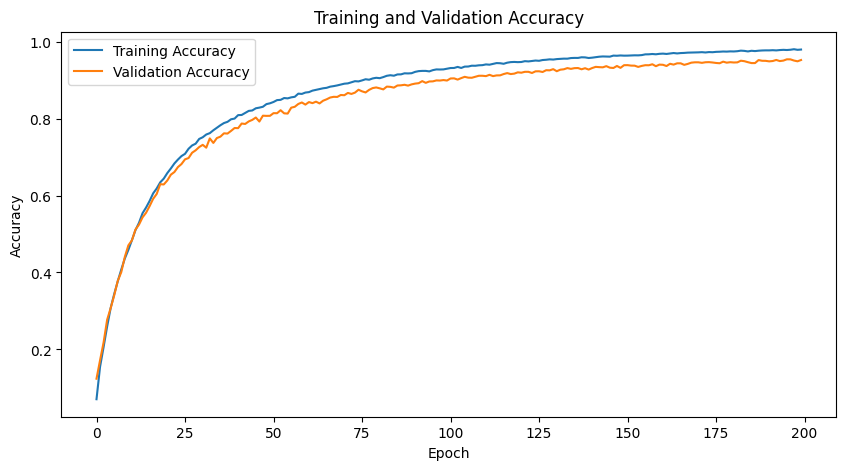

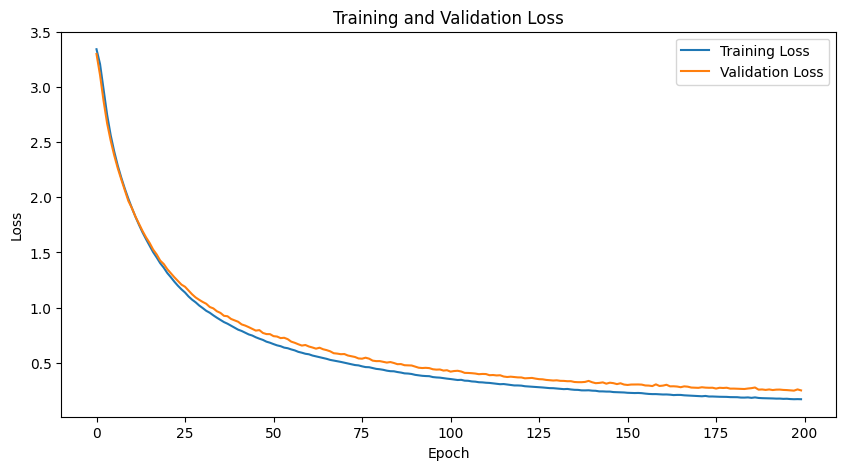

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy and loss from history
training_accuracy = history_student.history['accuracy']
validation_accuracy = history_student.history['val_accuracy']
loss = history_student.history['loss']
val_loss = history_student.history['val_loss']

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
def get_model_size_mb(model):
    total_size_bytes = 0
    for layer in model.layers:
        for weight in layer.weights:
            total_size_bytes += weight.numpy().nbytes
    total_size_mb = total_size_bytes / (1024 * 1024)
    return total_size_mb

# Get the size of the model in megabytes
model_size_mb = get_model_size_mb(student_model)
print("Model size: {:.2f} MB".format(model_size_mb))


import os

model_file_path = 'mobilenet_model_kd.h5'  # Replace 'my_model.h5' with the path to your .h5 file

# Get the size of the .h5 file in bytes
model_file_size_bytes = os.path.getsize(model_file_path)

# Convert the size to megabytes
model_file_size_mb = model_file_size_bytes / (1024 * 1024)

print("Model file size: {:.2f} MB".format(model_file_size_mb))


Model size: 1.40 MB
Model file size: 12.60 MB


In [ ]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

model_tf = tf.keras.models.load_model("mobilenet_model_kd.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_tf)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()


# Save the converted model to a .tflite file
with open("mobilenet_model_kd.tflite", "wb") as f:
    f.write(tflite_model)

from google.colab import files
files.download("mobilenet_model_kd.tflite")

model_file_path = 'mobilenet_model_kd.tflite'  # Replace 'my_model.h5' with the path to your .h5 file
model_file_size_bytes = os.path.getsize(model_file_path)
model_file_size_mb = model_file_size_bytes / (1024 * 1024)
print("Model file size: {:.2f} MB".format(model_file_size_mb))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model file size: 3.26 MB
